# AdBudget RL: Baselines, PPO and Recurrent PPO (LSTM)

This notebook demonstrates the full evaluation pipeline for the multi-channel
advertising budget environment:

1. **Equal-allocation baseline** (hand-crafted policy).
2. **PPO (MlpPolicy)** — feed-forward policy trained on the environment.
3. **Recurrent PPO (MlpLstmPolicy)** — LSTM-based policy that can track
   non-stationarity over time.

We assume that `adbudget_env.py` exists in the same directory and defines:

- `AdBudgetEnv`
- `ENV`, `TRAIN`, `EVAL` configuration dictionaries.

This notebook:

- Trains PPO and RecurrentPPO agents.
- Evaluates PPO, LSTM-PPO, and the equal-allocation baseline.
- Optionally plots learned allocation trajectories and cumulative profit.


## 1. Install dependencies (Colab / fresh environment)

If you are running this in Google Colab or a fresh environment, install the required
libraries first. On a local machine where you’ve already installed them, you can skip this.


In [3]:
## Uncomment in Colab / fresh environment:
# Core
!pip install -q "gymnasium==0.29.1" "stable-baselines3[extra]==2.3.0" "numpy>=1.23" "matplotlib>=3.8" "tensorboard>=2.16"
!pip install "stable-baselines3[extra]==2.3.0"
# Optional: dashboard + config
!pip install -q "streamlit>=1.37" "pyyaml>=6.0.1"
!pip install -U "ale-py==0.11.2" "shimmy>=0.2.1"
!python -m pip install --upgrade pip setuptools wheel
!python -m pip install "gymnasium==0.29.1" "stable-baselines3==2.3.0" numpy matplotlib tensorboard
!pip install "sb3-contrib==2.3.0"
!python -m pip show stable-baselines3


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement ale-py~=0.8.1; extra == "atari" (from shimmy[atari]) (from versions: 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.10.2, 0.11.0, 0.11.1, 0.11.2)
ERROR: No matching distribution found for ale-py~=0.8.1; extra == "atari"
  Using cached stable_baselines3-2.3.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This c

## 2. Imports and configuration

We import the environment and configs from `adbudget_env.py`, then bring in the
RL libraries and utilities:

- `PPO` and `RecurrentPPO`
- `DummyVecEnv` and `VecNormalize` for vectorised / normalised envs
- `Monitor` for logging
- `get_linear_fn` for linear learning-rate and clip-range schedules


In [22]:
from adbudget_env import AdBudgetEnv, ENV, TRAIN, EVAL

import numpy as np, json
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.utils import get_linear_fn
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO  # for LSTM-based agent

## 3. Quick environment sanity check

Before training any agents, we:

1. Instantiate `AdBudgetEnv()` with defaults.
2. Reset it and inspect:
   - Observation shape
   - Action space
3. Step through a few random actions to ensure everything runs without error.


In [12]:
env = AdBudgetEnv()
obs, info = env.reset()

print("Observation shape:", obs.shape)
print("Action space:", env.action_space)

for t in range(5):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    print(f"t={t}, reward={reward:.4f}, done={done}, truncated={truncated}")
    if done or truncated:
        print("Episode terminated early at t =", t)
        break


Observation shape: (26,)
Action space: Box(-20.0, 20.0, (4,), float32)
t=0, reward=0.4480, done=False, truncated=False
t=1, reward=0.6382, done=False, truncated=False
t=2, reward=0.9455, done=False, truncated=False
t=3, reward=1.0397, done=False, truncated=False
t=4, reward=1.0022, done=False, truncated=False


## 4. Baseline: Equal allocation

We define:

- `equal_allocation(n)`: returns a uniform allocation over `n` channels.
- Later, we will use this baseline by:
  - Converting the uniform allocation into logits (`log(alloc)`),
  - Feeding these logits into `env.step`.

This gives us a simple, intuitive benchmark: "split the budget evenly across all channels".


In [13]:
def equal_allocation(n: int) -> np.ndarray:
    """
    Equal-allocation baseline: return a uniform allocation over n channels.
    This is converted to logits (via log) before being passed to AdBudgetEnv.
    """
    return np.ones(n, dtype=np.float32) / float(n)


## 5. Initialize PPO (feed-forward MlpPolicy)

We now:

1. Build a vectorised environment:
   - `DummyVecEnv` with `TRAIN["num_envs"]` copies of `AdBudgetEnv`,
   - Each wrapped with `Monitor` for logging.
2. Wrap it with `VecNormalize` for:
   - Observation normalisation (`norm_obs=True`),
   - Reward normalisation (`norm_reward=True`).
3. Configure PPO with:
   - `n_steps` proportional to episode length and number of envs,
   - Linear schedules for learning rate and clip range,
   - Entropy coefficient, gamma, GAE lambda, etc. from `TRAIN`.
4. Add an entropy annealing callback:
   - Entropy coefficient decays from `TRAIN["ent_coef"]` to a small value
     over the course of training.

This cell **builds the PPO model but does not train it yet**.


In [16]:
class EntropyAnnealCallback:
    """
    Simple callback that linearly anneals entropy coefficient during training.

    Note: This is a lightweight version compatible with .learn(callback=...).
    """
    def __init__(self, start: float, end: float, total_timesteps: int):
        self.start = start
        self.end = end
        self.total = float(total_timesteps)
        self.num_timesteps = 0

    def __call__(self, locals_, globals_):
        # SB3 passes (locals, globals) to callback; we update ent_coef in model.
        self.num_timesteps = locals_["self"].num_timesteps
        model = locals_["self"]
        frac = min(1.0, self.num_timesteps / self.total)
        model.ent_coef = self.start + (self.end - self.start) * frac
        return True


def make_env(seed: int):
    """
    Factory for a monitored AdBudgetEnv, used inside DummyVecEnv.
    """
    def _fn():
        env = AdBudgetEnv(**{**ENV, "seed": seed})
        return Monitor(env)
    return _fn


NUM_ENVS = TRAIN["num_envs"]
EP_LEN = ENV["episode_len"]
# This follows your original code: n_steps is scaled by EP_LEN and NUM_ENVS.
n_steps = EP_LEN * NUM_ENVS * TRAIN["n_steps_mult"]

venv = DummyVecEnv([make_env(i) for i in range(NUM_ENVS)])
venv = VecNormalize(
    venv,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=10.0,
)

policy_kwargs = dict(
    net_arch=TRAIN["net_arch"],
    ortho_init=TRAIN["ortho_init"],
)

model_ppo = PPO(
    "MlpPolicy",
    venv,
    device=TRAIN["device"],
    n_steps=n_steps,
    batch_size=TRAIN["batch_size"],
    learning_rate=get_linear_fn(*TRAIN["learning_rate"], 1.0),
    clip_range=get_linear_fn(*TRAIN["clip_range"], 1.0),
    ent_coef=TRAIN["ent_coef"],
    gamma=TRAIN["gamma"],
    gae_lambda=TRAIN["gae_lambda"],
    vf_coef=TRAIN["vf_coef"],
    target_kl=TRAIN["target_kl"],
    max_grad_norm=TRAIN["max_grad_norm"],
    policy_kwargs=policy_kwargs,
    verbose=1,
    seed=TRAIN["seed"],
)

print("PPO (MlpPolicy) model created.")


Using cpu device
PPO (MlpPolicy) model created.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 480`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 480
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=120 and n_envs=4)
  warnings.warn(


## 6. Train PPO and save environment statistics

We train the PPO model for `TRAIN["total_timesteps"]` steps, with entropy
annealing. Then we:

- Save the VecNormalize statistics to `vecnorm.pkl`.
- Save the PPO model to `ppo_adbudget`.
- Save `ENV` to `env_kwargs.json` to reconstruct the same environment at eval time.

Notes:

- On CPU, this may take a few minutes (depending on `total_timesteps` and `num_envs`).
- You can reduce `TRAIN["total_timesteps"]` for a quick smoke test.
- After training, we:
  - Freeze `VecNormalize` in evaluation mode (`training=False`, `norm_reward=False`).
  - Save both the model and the normalisation statistics to disk.


In [18]:
total_timesteps = TRAIN["total_timesteps"]
print(f"Training PPO for {total_timesteps} timesteps...")

cb = EntropyAnnealCallback(
    start=TRAIN["ent_coef"],
    end=0.002,
    total_timesteps=total_timesteps,
)

# Use SB3 callback signature via lambda wrapper
model_ppo.learn(total_timesteps=total_timesteps, callback=cb)

venv.save("assets/vecnorm.pkl")
model_ppo.save("assets/ppo_adbudget")


# Save exact env params for eval reproducibility
with open("assets/env_kwargs.json", "w") as f:
    json.dump(ENV, f)

print("PPO training complete and artifacts saved:")
print(" - vecnorm.pkl")
print(" - ppo_adbudget")
print(" - env_kwargs.json")



Training PPO for 100000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 25.3     |
| time/              |          |
|    fps             | 1349     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 480      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30           |
|    ep_rew_mean          | 25.3         |
| time/                   |              |
|    fps                  | 1195         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 960          |
| train/                  |              |
|    approx_kl            | 0.015635725  |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_varian

NameError: name 'json' is not defined

## 7. Train Recurrent PPO (LSTM policy)

Now we train a **recurrent** policy using `RecurrentPPO` with `MlpLstmPolicy`.

Motivation:
- The environment is **non-stationary**: hidden parameters drift over time.
- An LSTM can, in principle, track this drift using its hidden state.

Setup:
- A new `DummyVecEnv` with its own `VecNormalize` (separate stats from PPO).
- `NUM_ENVS_LSTM` (e.g., 8) parallel environments.
- RecurrentPPO with:
  - `MlpLstmPolicy`
  - One LSTM layer of size 128 (configurable via `policy_kwargs`)
- We train for more timesteps than PPO (e.g., 1e6) to let the LSTM learn temporal patterns.


In [23]:
# LSTM / Recurrent PPO training

NUM_ENVS_LSTM = 8          # you can adjust; separate from TRAIN["num_envs"]
EP_LEN = ENV["episode_len"]
n_steps_lstm = EP_LEN * NUM_ENVS_LSTM * TRAIN["n_steps_mult"]

def make_env_lstm(seed: int):
    """
    Factory for LSTM training envs. We use the same ENV config but different seeds.
    """
    def _fn():
        return AdBudgetEnv(**{**ENV, "seed": seed})
    return _fn

venv_lstm = DummyVecEnv([make_env_lstm(ENV["seed"] + i) for i in range(NUM_ENVS_LSTM)])
venv_lstm = VecNormalize(
    venv_lstm,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=10.0,
)

policy_kwargs_lstm = dict(
    lstm_hidden_size=128,
    n_lstm_layers=1,
    net_arch=[256],   # MLP part after LSTM
)

model_lstm = RecurrentPPO(
    "MlpLstmPolicy",
    venv_lstm,
    device=TRAIN["device"],
    n_steps=n_steps_lstm,
    batch_size=TRAIN["batch_size"],
    learning_rate=get_linear_fn(*TRAIN["learning_rate"], 1.0),
    clip_range=get_linear_fn(*TRAIN["clip_range"], 1.0),
    ent_coef=TRAIN["ent_coef"],
    gamma=TRAIN["gamma"],
    gae_lambda=TRAIN["gae_lambda"],
    vf_coef=TRAIN["vf_coef"],
    target_kl=TRAIN["target_kl"],
    max_grad_norm=TRAIN["max_grad_norm"],
    policy_kwargs=policy_kwargs_lstm,
    verbose=1,
    seed=TRAIN["seed"],
)

print("RecurrentPPO (MlpLstmPolicy) model created.")

# Train LSTM agent
total_timesteps_lstm = TRAIN["total_timesteps"]
print(f"Training RecurrentPPO for {total_timesteps_lstm} timesteps...")

model_lstm.learn(total_timesteps=total_timesteps_lstm)

venv_lstm.save("assets/vecnorm_lstm.pkl")
model_lstm.save("assets/rppo_adbudget_lstm")

print("RecurrentPPO training complete and artifacts saved:")
print(" - vecnorm_lstm.pkl")
print(" - rppo_adbudget_lstm")


Using cpu device
RecurrentPPO (MlpLstmPolicy) model created.
Training RecurrentPPO for 100000 timesteps...
-----------------------------
| time/              |      |
|    fps             | 1996 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1920 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 548          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 3840         |
| train/                  |              |
|    approx_kl            | 0.0045558354 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.198        |
|    entropy_loss         | -5.68        |
|    explained_variance   | -0.03198254  |
|    learning_rate        | 0.000295     |
|    loss                 | 1.35         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00493  

## 8. Helper: Rebuild environment from saved JSON

At evaluation time, we want to reconstruct the **same environment configuration**
used during training. We stored that in `env_kwargs.json`.

The helper `make_env_from_json(seed)`:

- Loads `env_kwargs.json`,
- Optionally overrides the seed,
- Returns a fresh `AdBudgetEnv(**env_kwargs)`.


In [26]:
def make_env_from_json(seed: int | None = None) -> AdBudgetEnv:
    """
    Recreate the environment with the exact kwargs used during PPO training.
    """
    with open("assets/env_kwargs.json", "r") as f:
        env_kwargs = json.load(f)
    if seed is not None:
        env_kwargs["seed"] = seed
    return AdBudgetEnv(**env_kwargs)


## 9. Evaluation functions

We now define three evaluation functions:

1. `eval_agent()`:
   - Loads `vecnorm.pkl` and `ppo_adbudget`,
   - Evaluates the **PPO MlpPolicy** agent.

2. `eval_lstm()`:
   - Loads `vecnorm_lstm.pkl` and `rppo_adbudget_lstm`,
   - Evaluates the **RecurrentPPO (MlpLstmPolicy)** agent.
   - Manages recurrent state (`state`) and `episode_start` flags.

3. `eval_equal()`:
   - Directly runs `AdBudgetEnv` (no VecNormalize),
   - Uses the **equal-allocation baseline**:
     - Computes alloc = uniform,
     - Converts to logits via `log(alloc)`,
     - Feeds logits to `env.step`.
   - Uses multiple episodes and returns mean ± std return.


In [24]:
def eval_agent(episodes: int = EVAL["episodes"]) -> tuple[float, float]:
    """
    Evaluate PPO (MlpPolicy) agent.
    """
    venv_eval = DummyVecEnv([lambda: make_env_from_json(1000)])
    vec = VecNormalize.load("assets/vecnorm.pkl", venv_eval)
    vec.training = False
    vec.norm_reward = False

    model = PPO.load("assets/ppo_adbudget", device=TRAIN["device"])

    returns = []
    for ep in range(episodes):
        obs = vec.reset()
        ret = 0.0
        done = False
        while not done:
            act, _ = model.predict(obs, deterministic=True)
            obs, r, done_vec, _ = vec.step(act)
            ret += float(r[0])
            done = bool(done_vec[0])
        returns.append(ret)

    return float(np.mean(returns)), float(np.std(returns))


def eval_lstm(episodes: int = EVAL["episodes"]) -> tuple[float, float]:
    """
    Evaluate RecurrentPPO (MlpLstmPolicy) agent.
    """
    venv_eval = DummyVecEnv([lambda: make_env_from_json(1000)])
    vec = VecNormalize.load("assets/vecnorm_lstm.pkl", venv_eval)
    vec.training = False
    vec.norm_reward = False

    model = RecurrentPPO.load("rppo_adbudget_lstm", device=TRAIN["device"])

    returns = []
    for ep in range(episodes):
        obs = vec.reset()
        state = None
        episode_start = np.array([True], dtype=bool)
        ret = 0.0
        done = False
        while not done:
            act, state = model.predict(
                obs,
                state=state,
                episode_start=episode_start,
                deterministic=True,
            )
            obs, r, done_vec, _ = vec.step(act)
            ret += float(r[0])
            done = bool(done_vec[0])
            episode_start[:] = done_vec
        returns.append(ret)

    return float(np.mean(returns)), float(np.std(returns))


def eval_equal(episodes: int = EVAL["episodes"]) -> tuple[float, float]:
    """
    Evaluate equal-allocation baseline directly on the raw AdBudgetEnv.

    Note: No VecNormalize here; we compare on the raw reward scale.
    """
    env = make_env_from_json(2000)
    returns = []
    for i in range(episodes):
        obs, _ = env.reset(seed=2000 + i)
        ret = 0.0
        done = False
        truncated = False
        while not (done or truncated):
            alloc = equal_allocation(env.n)
            logits = np.log(alloc + 1e-12).astype(np.float32)
            obs, r, done, truncated, _ = env.step(logits)
            ret += r
        returns.append(ret)

    return float(np.mean(returns)), float(np.std(returns))


## 10. Run all evaluations: PPO, LSTM-PPO, Equal Baseline

We now run:

- `eval_agent()` for PPO,
- `eval_lstm()` for RecurrentPPO,
- `eval_equal()` for the equal-allocation baseline,

and print the mean and standard deviation of returns for each.


In [27]:
ppo_mean, ppo_std = eval_agent()
lstm_mean, lstm_std = eval_lstm()
eq_mean, eq_std = eval_equal()

results = {
    "PPO_mean": ppo_mean,
    "PPO_std": ppo_std,
    "LSTM_PPO_mean": lstm_mean,
    "LSTM_PPO_std": lstm_std,
    "Equal_mean": eq_mean,
    "Equal_std": eq_std,
}
results


{'PPO_mean': 32.81093660593033,
 'PPO_std': 5.14145196754996,
 'LSTM_PPO_mean': 35.15381474718451,
 'LSTM_PPO_std': 2.9823209992836697,
 'Equal_mean': 27.629545175461153,
 'Equal_std': 2.461903708683975}

## 11. Optional: Plot allocations and cumulative profit for LSTM-PPO agent

This section:

1. Loads the LSTM policy and its VecNormalize stats.
2. Runs a single episode deterministically.
3. Tracks:
   - Allocation per channel per day,
   - Immediate profit (reward) per day.
4. Plots:
   - Allocation ratio per channel vs. time,
   - Cumulative profit vs. time.

This gives a visual sense of how the learned policy behaves.


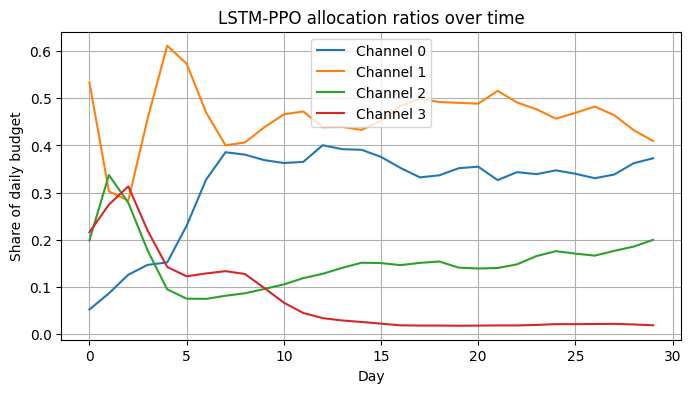

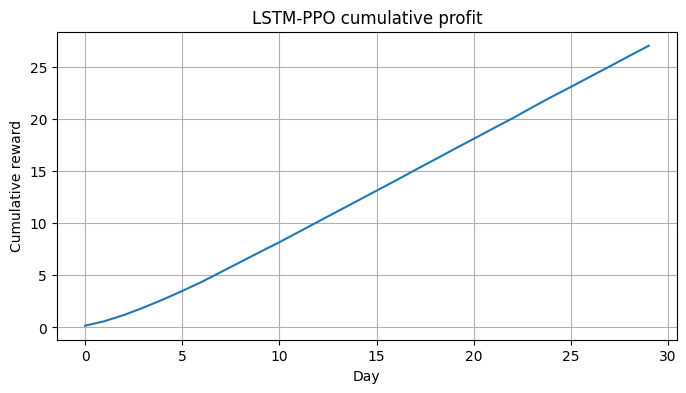

In [28]:
import matplotlib.pyplot as plt

EP_LEN = ENV["episode_len"]

def plot_allocation_and_profit():
    # build a 1-env VecNormalize with saved stats
    venv = DummyVecEnv([lambda: make_env_from_json(1234)])
    vec  = VecNormalize.load("assets/vecnorm_lstm.pkl", venv)
    vec.training = False
    vec.norm_reward = False

    model = RecurrentPPO.load("assets/rppo_adbudget_lstm", device=TRAIN["device"])

    # For inspection of internals (alloc, params), we need underlying env
    base_env: AdBudgetEnv = vec.venv.envs[0]  # type: ignore
    n = base_env.n

    obs = vec.reset()   # shape (1, obs_dim)
    allocs, profits = [], []
    done = False
    state = None
    episode_start = np.array([True], dtype=bool)

    while not done:
        act, state = model.predict(
            obs,
            state=state,
            episode_start=episode_start,
            deterministic=True,
        )
        # Track allocation used by env: softmax over raw action
        logits = act[0]
        z = logits - logits.max()
        alloc = np.exp(z) / np.clip(np.exp(z).sum(), 1e-8, np.inf)
        allocs.append(alloc)

        obs, rew, dones, infos = vec.step(act)
        profits.append(float(rew[0]))
        done = bool(dones[0])
        episode_start[:] = dones

    allocs = np.asarray(allocs)

    # Plot allocation ratios
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.plot(allocs[:, i], label=f"Channel {i}")
    plt.title("LSTM-PPO allocation ratios over time")
    plt.xlabel("Day")
    plt.ylabel("Share of daily budget")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot cumulative profit
    profits = np.asarray(profits)
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(profits))
    plt.title("LSTM-PPO cumulative profit")
    plt.xlabel("Day")
    plt.ylabel("Cumulative reward")
    plt.grid(True)
    plt.show()

plot_allocation_and_profit()
